# This notebook is to build methods to quantify network quality

# Table of contents
## <a href='#Evaluation-1:-scale-free-network-assumption'>1. Scale free check</a>
## <a href='#Evaluation-2:-compare-network-distance-by-GED-and-deltacon'>2. Compare network distance</a>
## <a href='#Evaluation-3:-compare-network-modules-by-Jaccard'>3. Compare netowrk modules</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import netcomp
from itertools import combinations
from sklearn.metrics import normalized_mutual_info_score as nmi
from matplotlib import gridspec
from functions.eda_functions import *
from functions.subset_network import subset_network
from functions.process_phenotype import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Evaluate network quality with edge filtering

In [3]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)
# tom_df = pd.read_csv('/Volumes/GoogleDrive/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)

In [39]:
tom_df_subset = tom_df.iloc[:3000,:3000]

In [41]:
tom_df_subset.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\tom_subset.csv')

# Evaluation 1: scale-free network assumption

In [3]:
def subset_network1(network_df, weight_min, weight_max, num_edges):
    '''
    A function to subset a network using weight cutoff and num_edges
    Return the edgelist and the graph with the edges removed from the cutoff
    '''
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    subset_adj = subset.stack().reset_index() # convert from wide to long to determine # edges left    
    sorted_subset_adj = subset_adj.sort_values(0, ascending = False)
    if num_edges > len(sorted_subset_adj)*2:
        print(f'not enough edges to filter with at the cutoff of {num_edges}')
    else:
        sorted_subset_adj_filtered = sorted_subset_adj.iloc[:num_edges*2, :]
        new_subset_adj = sorted_subset_adj_filtered.pivot(index = 'level_0', columns = 'level_1').fillna(0)
        new_subset_adj.columns = new_subset_adj.columns.droplevel()
        G = nx.convert_matrix.from_pandas_adjacency(new_subset_adj)
    return new_subset_adj, G

In [4]:
def subset_network2(network_df, weight_min, weight_max):
    '''
    A function to subset a network using weight cutoff
    Return the adjacency matrix and the graph with the edges NOT removed from the cutoff to keep the same # nodes as the original graph so the graph distance could be compared
    '''
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    subset_adj = subset.stack() # convert from wide to long to determine # edges left
    print('Number of edges left:',len(subset_adj)/2)
    subset = subset.fillna(0)    
    G = nx.convert_matrix.from_pandas_adjacency(subset)
    return subset, G

In [22]:
def scale_free_validate(network_df):
    network_degree = network_df.sum()
    log_network_degree = np.log(network_degree)
    sorted_network_freq = round(log_network_degree,1).value_counts().reset_index()
    sorted_network_freq[0] = np.log(sorted_network_freq[0])
    plt.scatter(sorted_network_freq.index, sorted_network_freq[0])
    plt.xlabel('log(k)')
    plt.ylabel('log(pk)')
    plt.show()
    plt.close();

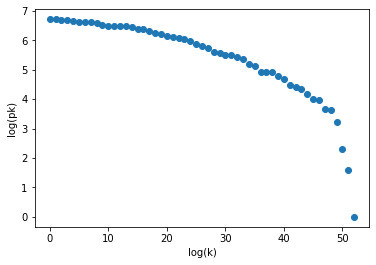

In [6]:
# Original network with no cutoff
scale_free_validate(tom_df)

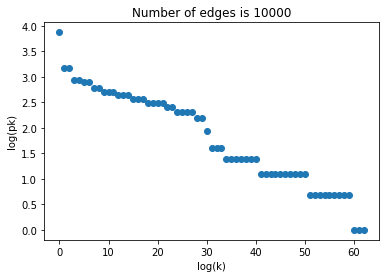

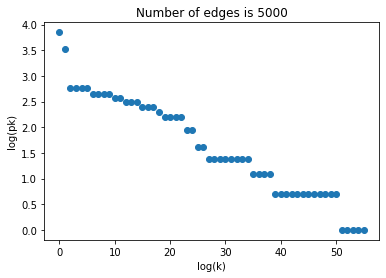

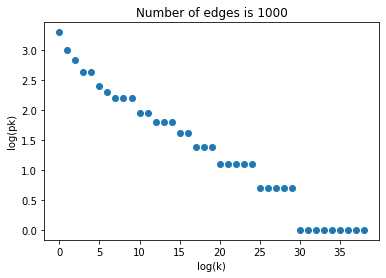

In [23]:
subset_networks = []
for edge in [10000,5000,1000]:
    subset, G = subset_network(tom_df, 0.21, 0.99, edge)
    subset_networks.append(subset) 
    plt.title(f'Number of edges is {edge}')
    scale_free_validate(subset)

# Evaluation 2: compare network distance by GED and deltacon

## Note to use DeltaCon, the graphs need to have the same number of nodes so just replace edges with small weights with 0

In [24]:
subset_networks2 = []
subset_G = []
for weight in [0.218, 0.24, 0.278]:
    subset, G = subset_network(tom_df, weight, 0.98)
    subset_networks2.append(subset)
    subset_G.append(G)

Number of edges left: 10100.0
Number of edges left: 4967.0
Number of edges left: 1092.0


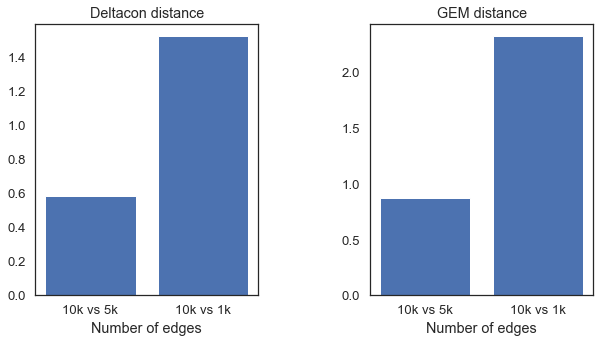

In [370]:
plot_graph_distance(subset_df, ['10k', '5k', '1k'])

# Evaluation 3: compare network modules

## Evaluation 3a: comparison by jaccard

In [25]:
tom_df_subset = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\tom_subset.csv', index_col = 0)

In [12]:
def run_louvain(adjacency_df):
    # louvain communities
    louvain = Louvain(modularity = 'Newman')
    labels = louvain.fit_transform(adjacency_df.values) # using networkx community requires converting the df to G first and the original network takes very long but this method can work on df 
    louvain_df = pd.DataFrame({'id':adjacency_df.index, 'louvain_label':labels})
    return louvain_df

In [13]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = len(set(list1)) + len(set(list2)) - intersection
    return intersection / union

In [32]:
def add_cutout_node_cluster(community_df1, community_df2):
    community_df2.louvain_label = community_df2.louvain_label.apply(lambda x:(x+1)) # add 1 to each of the cluster id 
    diff_nodes = set(community_df1.id.unique()) - set(community_df2.id.unique())
    cutout_node_cluster = pd.DataFrame({'id':list(diff_nodes), 'louvain_label':0}) # assign the nodes that were cut out in cluster 0 
    community_df2 = pd.concat([cutout_node_cluster, community_df2])
    return community_df2

In [39]:
def community_jaccard(community_df1, community_df2, title, cutout_nodes = False, top = None):
    '''
    plot jaccard pairwise comparison on the communities in 2 networks
    title: main title for each plot
    top: top n comparison to show in the boxplot since it could be misleadingly small if we include all jaccard scores
    # we're only interested in the modules that have majority of the matching nodes between 2 networks
    '''
    c1_list = []
    c2_list = []
    j_list = []
    if cutout_nodes == False:
        community_df2 = add_cutout_node_cluster(community_df1, community_df2)
    
    for c1 in community_df1.louvain_label.unique():
        for c2 in community_df2.louvain_label.unique():
            sub1 = community_df1[community_df1.louvain_label == c1].index
            sub2 = community_df2[community_df2.louvain_label == c2].index
            c1_list.append(c1)
            c2_list.append(c2)
            j_list.append(jaccard_similarity(sub1, sub2))
            
    jac_df = pd.DataFrame({'community1':c1_list, 'community2':c2_list, 'jaccard':j_list})
    jac_df = jac_df.pivot(index = 'community1', columns = 'community2', values = 'jaccard')
    sns.set(font_scale=1.2)
    sns.set_style('white')
    h = len(community_df1.louvain_label.unique())/2
    w = len(community_df2.louvain_label.unique())/2
    fig = plt.figure(figsize = (w, h))
    gs = gridspec.GridSpec(1,2, width_ratios = [3,1]) # set the subplot width ratio
    ax0 = plt.subplot(gs[0])
    # plot heatmap for pairwise jaccard comparison
    sns.heatmap(jac_df, cmap = 'Reds', xticklabels=True, yticklabels=True)
    plt.ylabel('Whole network')
    plt.xlabel('subnetwork')
    plt.title('Jaccard pairwise module comparison')
    plt.xticks(rotation=0)
    ax1 = plt.subplot(gs[1])
    # boxplot of jaccard distribution
    all_jac_values = jac_df.values.flatten()
    if top != None:
        sorted_jac_values = sorted(all_jac_values, reverse = True)
        sns.boxplot(x= None, y = sorted_jac_values[:top])
    else:
        sns.boxplot(x= None, y = all_jac_values)
    plt.ylim(0,1)
    plt.title('Jaccard distribution')
    plt.suptitle(title)

In [34]:
original_community = run_louvain(tom_df)

In [30]:
# original_community.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_louvain_default.csv')
original_community = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_louvain_default.csv', index_col = 0)

In [26]:
subset_communities = []
for subset in subset_networks:
    subset_communities.append(run_louvain(subset))

### Louvain determined the original network had 10 modules only instead of the 26 in the paper but bc I don't know how to translate the method used in WCGNA to Python codes. All I know is WCGNA used hierarchical clustering unless I dig in to the codes or run the clustering on the subsets with WCGNA. For now, all the network modules are detected with louvain

## Evaluation 3a: comparison number of nodes in each community

Text(0.5, 1.0, '# nodes in each community for the whole network')

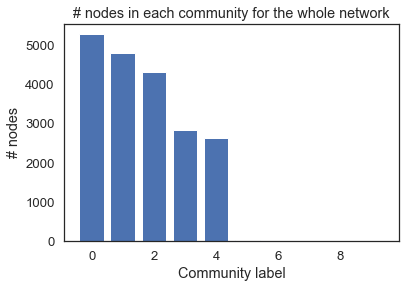

In [58]:
plt.bar(original_community.louvain_label.value_counts().index, original_community.louvain_label.value_counts().values)
plt.ylabel('# nodes')
plt.xlabel('Community label')
plt.title('# nodes in each community for the whole network')

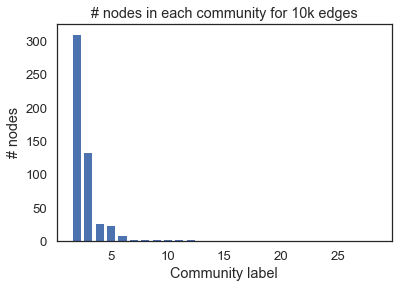

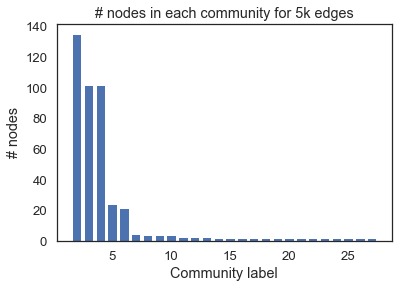

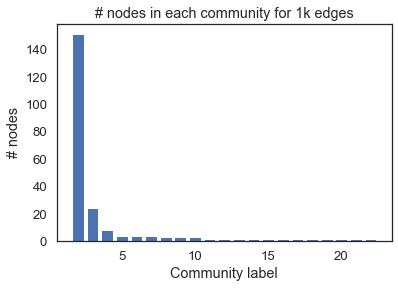

In [57]:
subset_names = ['10k edges', '5k edges', '1k edges']
for i, subset_com in enumerate(subset_communities):
    plt.bar(subset_com.louvain_label.value_counts().index, subset_com.louvain_label.value_counts().values)
    plt.ylabel('# nodes')
    plt.xlabel('Community label')
    plt.title(f'# nodes in each community for {subset_names[i]}')
    plt.show()
    plt.close()

## Evaluation 3b.1: comparison by jaccard (nodes with degree = 0 as cluster 0)

In [28]:
subset_communities[1].head()

,id,louvain_label
0,ENSG00000001626,1
1,ENSG00000004864,1
2,ENSG00000005513,0
3,ENSG00000005893,0
4,ENSG00000006042,0


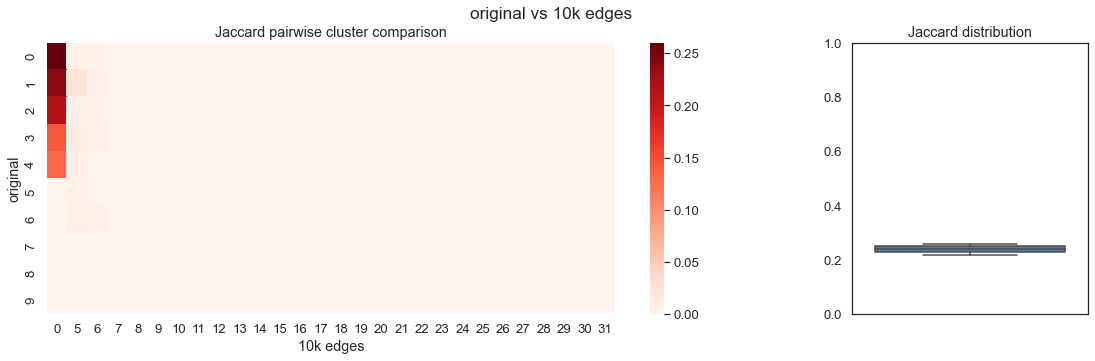

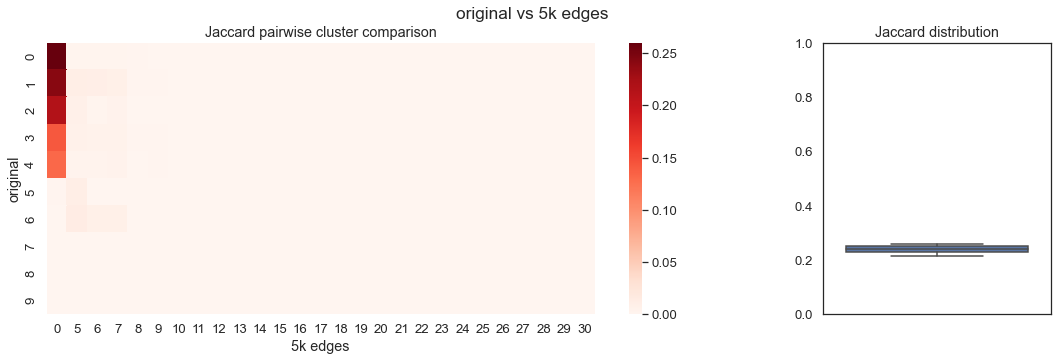

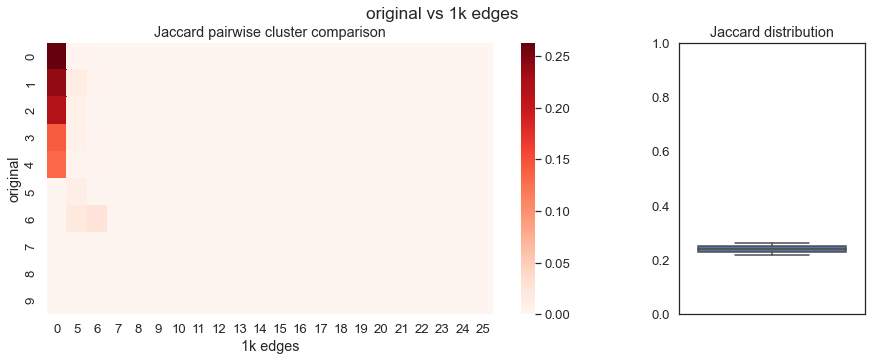

In [38]:
subset_names = ['10k edges', '5k edges', '1k edges']
for i, subset_com in enumerate(subset_communities):
    cluster_jaccard(original_community, subset_com, 'louvain_label', ['original', subset_names[i]], cutout_nodes = False, top=3)

## Evaluation 3b.2: comparison by jaccard (nodes with degree = 0 excluded)

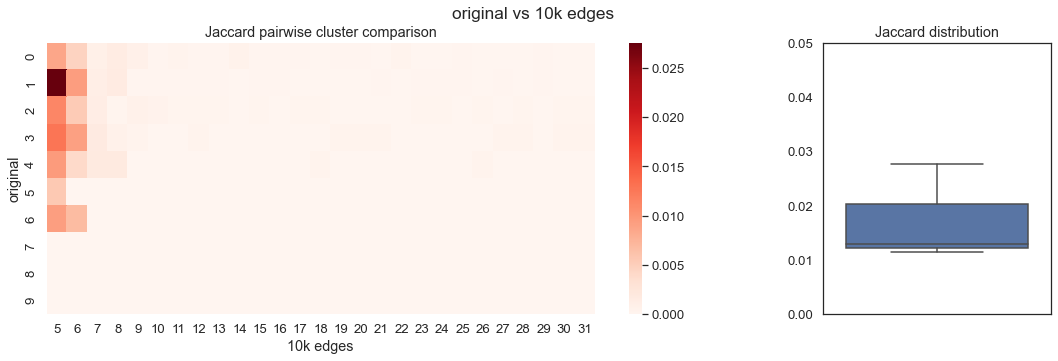

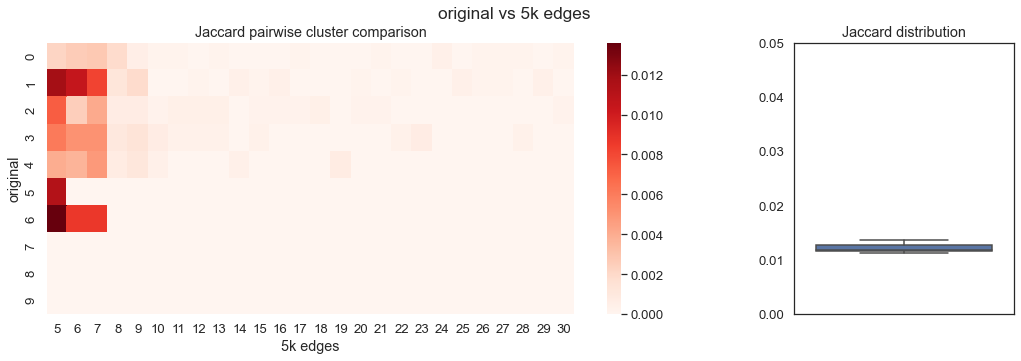

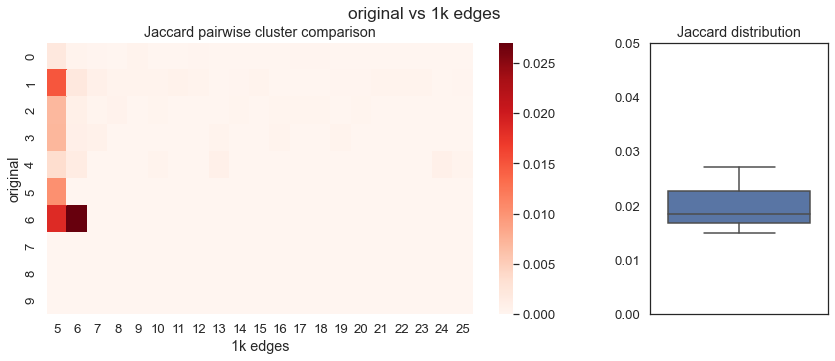

In [40]:
subset_names = ['10k edges', '5k edges', '1k edges']
for i, subset_com in enumerate(subset_communities):
    cluster_jaccard(original_community, subset_com, 'louvain_label', ['original', subset_names[i]], cutout_nodes = True, top=3, y_max = 0.05)

## Evaluation 3c: comparison by normalized mutual information

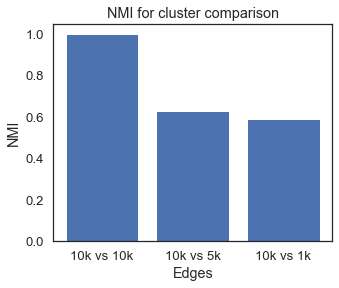

In [63]:
plot_cluster_nmi_comparison(subset_communities[0], subset_communities, 
                            'louvain_label', ['10k vs 10k', '10k vs 5k', '10k vs 1k'])

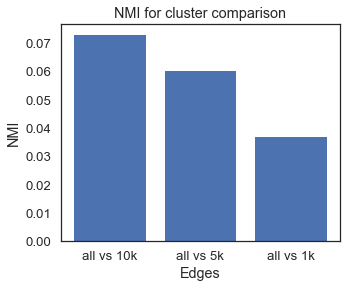

In [65]:
plot_cluster_nmi_comparison(original_community, subset_communities, 
                            'louvain_label', ['all vs 10k', 'all vs 5k', 'all vs 1k'])